# Bayse Model

In [48]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph

In [49]:
filepath = "../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df = df.dropna()

/tmp/ipykernel_11463/1695517033.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()


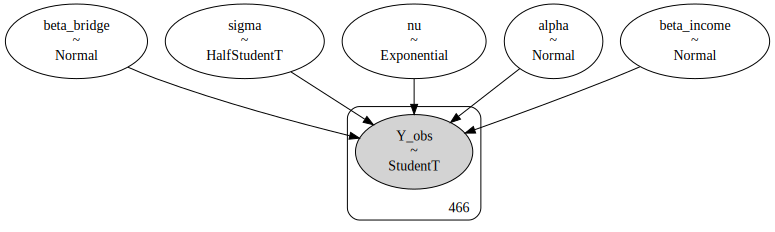

In [50]:
population = df['population_change_rate'].values
bridge = df['dummy_after_bridge_opened'].values
log_income = df['log_income'].values

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0.0256, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0.066, sigma=100)
    beta_income = pm.Normal('beta_income', mu=-0.0115, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=4, sigma=100)
    nu = pm.Exponential('nu', lam=1/30)

    # linear model
    mu = alpha + beta_bridge * bridge + beta_income * log_income

    # Likelihood
    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=nu, observed=population)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
graph.render(filename='../../visualization/graphviz/bm_t_5years', format='png', cleanup=True)
graph

In [4]:
with model:
    idata = pm.sample(
        draws=10000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        chains=4,
        target_accept=.95,
    )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [5]:
az.to_netcdf(idata, '../mcmc_results/t_5years.nc')

'../mcmc_results/t_5years.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.108,0.045,0.021,0.190,0.000,0.000,18115.0,21145.0,1.0
beta_bridge,0.057,0.009,0.039,0.074,0.000,0.000,25452.0,23585.0,1.0
beta_income,-0.015,0.003,-0.020,-0.011,0.000,0.000,18352.0,20906.0,1.0
sigma,0.075,0.005,0.066,0.084,0.000,0.000,19132.0,22494.0,1.0
nu,2.513,0.350,1.892,3.185,0.003,0.002,18985.0,20991.0,1.0


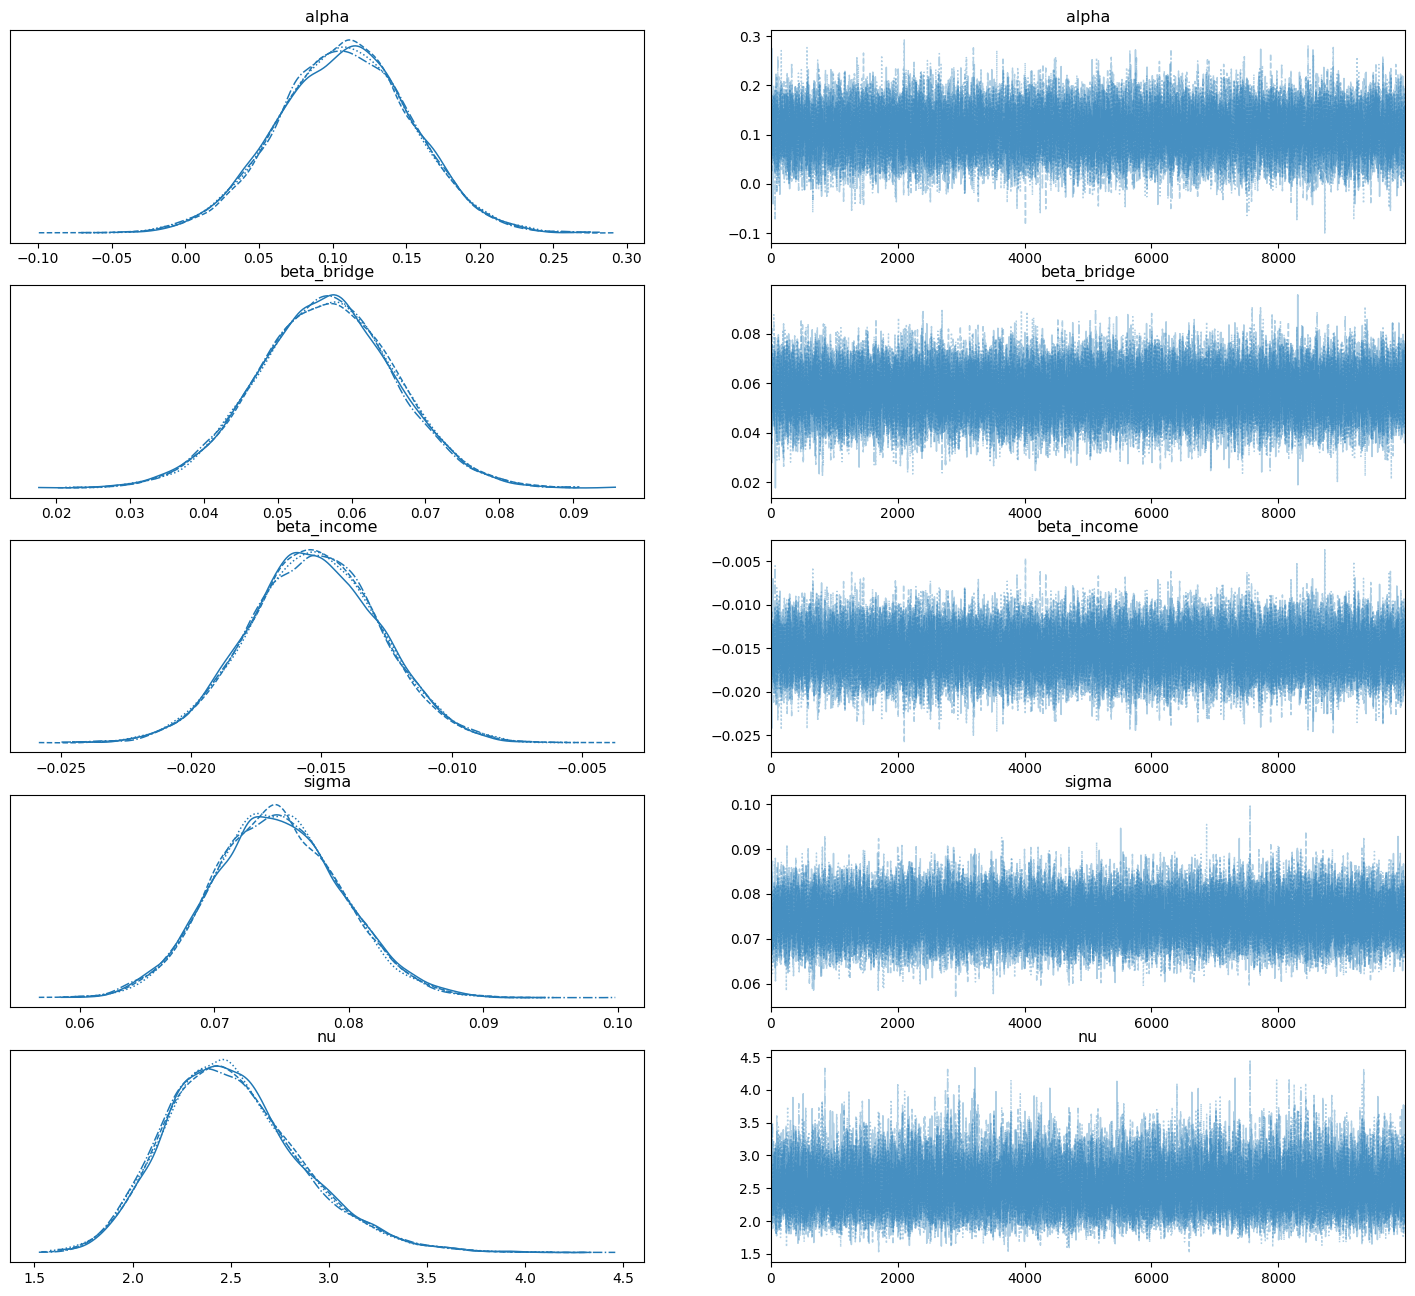

In [6]:
az.plot_trace(idata, figsize=(18, 16))  # サイズを調整
az.summary(idata)

# 橋ダミーのパラメータが0以上である確率

In [55]:
posterior_samples = idata.posterior

beta_bridge_samples = posterior_samples['beta_bridge']

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(beta_bridge_samples >= 0)

print(f"P(beta_1 >= 0) = {prob_beta_bridge_positive:.4f}")

P(beta_1 >= 0) = 1.0000
